In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
X_train = np.load('exam2_train_x.npy')
X_train = np.asarray(X_train, dtype=np.float32)
X_train = X_train/255 - 0.5
Y_train = np.load('exam2_train_y.npy')
Y_train = np.asarray(Y_train, dtype=np.int32)
# Y_train_onehot = ryan_onehot(Y_train, 0)

X_test = np.load('exam2_test_x.npy')
X_test = np.asarray(X_test, dtype=np.float32)
X_test = X_test/255 - 0.5
Y_test = np.load('exam2_test_y.npy')
Y_test = np.asarray(Y_test, dtype=np.int32)
# Y_test_onehot = ryan_onehot(Y_test, 0)


In [3]:
tf.set_random_seed(1)
batch = 60

X = tf.placeholder(tf.float32, [None,64,64,3])
Y = tf.placeholder(tf.int32, [None,])
flag = tf.placeholder(tf.bool)

# Conv + pool 1
conv1 = tf.layers.conv2d(
    inputs=X,
    filters=20,
    kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=1,dtype=tf.float32),
    bias_initializer=tf.constant_initializer(0, dtype=tf.float32),
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.crelu)
pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)

# Conv + pool 2
conv2 = tf.layers.conv2d(
    inputs=pool1,
    filters=60,
    kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False,seed=1,dtype=tf.float32),
    bias_initializer=tf.constant_initializer(0, dtype=tf.float32),
    kernel_size=[5, 5],
    padding="same",
    activation=tf.nn.elu)
pool2 = tf.layers.max_pooling2d(inputs=conv2, pool_size=[2, 2], strides=2)

# Flatten
pool2_flat = tf.reshape(pool2, [-1, 16 * 16 * 60])

# Dense 1
dense1 = tf.layers.dense(
    inputs=pool2_flat, 
    units=200,
    kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False, seed=1),
    bias_initializer=tf.zeros_initializer(),
    activation=tf.nn.crelu)
dropout1 = tf.layers.dropout(inputs=dense1, rate=0.7, seed=1, training=flag)

# Output Layer
logits = tf.layers.dense(
    inputs=dropout1,
    kernel_initializer=tf.contrib.layers.xavier_initializer(uniform=False, seed=1),
    bias_initializer=tf.zeros_initializer(),
    units=6)

soft_max = tf.nn.softmax(logits)
predictions = tf.argmax(soft_max, axis=1)

loss = tf.losses.sparse_softmax_cross_entropy(labels=Y, logits=logits)

bat = tf.Variable(0, trainable = False)
learning_rate = tf.train.exponential_decay(0.001, bat * batch, 1020, 0.98, staircase=True)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss, global_step=bat)

init = tf.global_variables_initializer()
with tf.Session() as sess:
    sess.run(init)
    costs = []
    costs1 = []
    for j in range(57):
        c = 0
        for i in range(0, 1020, batch):
            _, temp = sess.run([optimizer, loss], feed_dict={X:X_train[i:i+batch], Y:Y_train[i:i+batch], flag:True})
            c += temp
        
        
        c1 = sess.run(loss, feed_dict={X:X_test, Y:Y_test, flag:True})
        costs1.append(c1)
        costs.append(c/(1020/batch))
        
        #print out
        pred = sess.run(predictions, feed_dict={X:X_train, flag:False})
        count = 0
        for i in range(pred.shape[0]):
            if(pred[i] != Y_train[i]):
                count += 1
        trainA = 1.0-count/pred.shape[0]

        test_pred = sess.run(predictions, feed_dict={X:X_test, flag:False})
        count = 0
        for i in range(len(test_pred)):
            if(test_pred[i] != Y_test[i]):
                count += 1
        testA = 1.0-count/len(test_pred)
        
        print("Iteration: {0:<4} | Train accuracy: {1:5.5f} | Test accuracy: {2:5.5f}".format(j, trainA, testA))
        print('------------------------------------------------------------------')
    

Iteration: 0    | Train accuracy: 0.54510 | Test accuracy: 0.50000
------------------------------------------------------------------
Iteration: 1    | Train accuracy: 0.75588 | Test accuracy: 0.72222
------------------------------------------------------------------
Iteration: 2    | Train accuracy: 0.88137 | Test accuracy: 0.80000
------------------------------------------------------------------
Iteration: 3    | Train accuracy: 0.91078 | Test accuracy: 0.83889
------------------------------------------------------------------
Iteration: 4    | Train accuracy: 0.94118 | Test accuracy: 0.87778
------------------------------------------------------------------
Iteration: 5    | Train accuracy: 0.93922 | Test accuracy: 0.85556
------------------------------------------------------------------
Iteration: 6    | Train accuracy: 0.97941 | Test accuracy: 0.90556
------------------------------------------------------------------
Iteration: 7    | Train accuracy: 0.97647 | Test accuracy: 0.9

Iteration: 62   | Train accuracy: 1.00000 | Test accuracy: 0.93333
------------------------------------------------------------------
Iteration: 63   | Train accuracy: 1.00000 | Test accuracy: 0.93333
------------------------------------------------------------------
Iteration: 64   | Train accuracy: 1.00000 | Test accuracy: 0.94444
------------------------------------------------------------------
Iteration: 65   | Train accuracy: 1.00000 | Test accuracy: 0.93889
------------------------------------------------------------------
Iteration: 66   | Train accuracy: 1.00000 | Test accuracy: 0.94444
------------------------------------------------------------------
Iteration: 67   | Train accuracy: 1.00000 | Test accuracy: 0.93333
------------------------------------------------------------------
Iteration: 68   | Train accuracy: 1.00000 | Test accuracy: 0.93333
------------------------------------------------------------------
Iteration: 69   | Train accuracy: 1.00000 | Test accuracy: 0.9

In [4]:

#20 60 200 19 .95 relu 94444 0.6
#20 60 200 52 .98 elu 94444? 0.6
#20 60 200 24 .98 crelu elu crelu 9444 0.6
#20 60 200 25 .98 crelu elu crelu 9555 0.7
#40

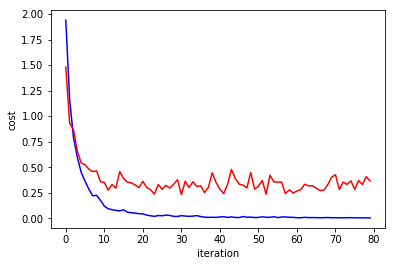

In [5]:
## Draw graph
plt.plot(np.arange(57), costs, "b-", costs1, "r-")
plt.xlabel('iteration')
plt.ylabel('cost')
plt.show()

In [6]:
print('______________________________________________________________________________________')
print('|layer|', 'type    |','size    |','channel    |','kernel    |','stride    |','padding    |','function|')
print('|     |', '        |','        |','           |','          |','          |','           |','        |')
print('|  0  |', 'input   |','64x64   |','3          |','          |','          |','           |','        |')
print('|  1  |', 'C1      |','64x64   |','20         |','5x5       |','1         |','same       |','CReLU   |')
print('|  1  |', 'P1      |','32x32   |','20         |','2x2       |','2         |','valid      |','Max     |')
print('|  2  |', 'C2      |','32x32   |','60         |','5x5       |','1         |','same       |','eLU     |')
print('|  2  |', 'P2      |','16x16   |','60         |','2x2       |','2         |','valid      |','Max     |')
print('|  3  |', 'F3      |','15360   |','           |','          |','          |','           |','        |')
print('|  4  |', 'F4      |','200     |','           |','          |','          |','           |','CReLU   |')
print('|  5  |', 'F5      |','6       |','           |','          |','          |','           |','Sigmoid |')
print('______________________________________________________________________________________')

______________________________________________________________________________________
|layer| type    | size    | channel    | kernel    | stride    | padding    | function|
|     |         |         |            |           |           |            |         |
|  0  | input   | 64x64   | 3          |           |           |            |         |
|  1  | C1      | 64x64   | 20         | 5x5       | 1         | same       | CReLU   |
|  1  | P1      | 32x32   | 20         | 2x2       | 2         | valid      | Max     |
|  2  | C2      | 32x32   | 60         | 5x5       | 1         | same       | eLU     |
|  2  | P2      | 16x16   | 60         | 2x2       | 2         | valid      | Max     |
|  3  | F3      | 15360   |            |           |           |            |         |
|  4  | F4      | 200     |            |           |           |            | CReLU   |
|  5  | F5      | 6       |            |           |           |            | Sigmoid |
_________________________________